# Modelo basado en agentes para la Asignacion de pacientes en sala de hospitalizaciones
**Autores:** Ana Sofía Gutiérrez, Salomón Cardeño, Isabella Quintero

In [166]:
# importar librerias
import numpy as np
import matplotlib.pyplot as plt
from functools import partial 

class Game:
    ''' Clase que define el juego de las enfermeras
    Parametros:
        n_patients: numero de pacientes que llegan al hospital
        n_enf: numero de enfermeras
        p_short_stay: probabilidad de que un paciente sea de corta estancia
        arrival_rate: tasa de llegada de pacientes al hospital
    '''
    def __init__ (self, n_patients, n_enf, p_short_stay, arrival_rate):
        self.n_patients=n_patients
        self.n_enf=n_enf
        self.p_short_stay=p_short_stay
        self.arrival_rate=arrival_rate
        self.reset_patients()
        self.experience_weight=np.arange(1,self.n_enf+1)/10
        
    def reset_patients (self):
        ''' Funcion que genera los pacientes que llegan al hospital'''
        stay_length=lambda kind: 1 if kind=='short' else 2
        self.patient_kind_stay=np.random.choice(['short','long'],p=[self.p_short_stay,1-self.p_short_stay],size=self.n_patients)
        self.patient_entry = np.random.exponential(scale=self.arrival_rate,size=(self.n_patients)).astype(int)
        self.patient_entry.sort()
        self.patient_entry+=np.arange(self.n_patients)-self.patient_entry.min()
        self.patient_stay=np.vectorize(stay_length)(self.patient_kind_stay)
        self.patient_exit = self.patient_entry + self.patient_stay
    
    def run_exp (self, funcion_acciones):
        ''' Funcion que ejecuta el juego de las enfermeras'''
        assignment=np.zeros((self.n_enf,self.n_patients)) 
        u_time, u_penal = np.zeros((self.patient_exit.max()+1, self.n_enf)), np.zeros((self.patient_exit.max()+1, self.n_enf))

        for patient in self.patient_entry.argsort():
            tick=self.patient_entry[patient]
            
            # ¿a qué enfermera se le asigna?
            enf, voluntario=funcion_acciones(assignment=assignment,n_enf=self.n_enf,patient=patient)

            # si ninguna enfermera acepta, se asigna a la que menos pacientes tenga
            if not voluntario: u_penal[tick:self.patient_exit[patient]+1,enf]=1

            # actualizar la ocupacion/pago de las enfermeras
            assignment[enf,patient]=self.patient_exit[patient]
            u_time[tick:self.patient_exit[patient]+1,enf]+=1
            assignment[assignment<=tick]=0 # eliminar a los pacientes que ya se han ido
        
        return self.fix_utilities(u_time,u_penal)

    def fix_utilities(self,u_time,u_penal):
        ''' Funcion que calcula la utilidad de las enfermeras: combinacion de la utilidad por tiempo y la penalizacion por rechazar pacientes'''
        return u_time * self.experience_weight + u_penal * self.experience_weight[::-1]
    
    def summarize_utilities(self,u):
        ''' Funcion que resume las utilidades de las enfermeras en cada periodo donde de decidio una asignacion de pacientes'''
        return np.array([x.sum(axis=0) for x in np.split(u,self.patient_entry[1:])])
    
    def plot_pagos(self,u,titulo=''):
        fig, ax=plt.subplots(figsize=(10,3))
        plt.plot(u, marker='o',markersize=3,linestyle=':',drawstyle = 'steps-post')
        fig.legend(['U_%i'%i for i in range(u.shape[0])],bbox_to_anchor=(1,1.04),ncol=u.shape[0])
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title('funcion de pagos de los agentes '+titulo)
        plt.xlabel('tiempo'); plt.ylabel('utilidad')
        fig.tight_layout()
        return fig
    
    def plot_pacientes(self,titulo=''):
        fig, ax=plt.subplots(figsize=(10,3))
        for  y, x1, x2 in zip(range(self.n_patients), self.patient_entry, self.patient_exit):
            plt.plot([x1,x2], [y+1, y+1], '|-', label='paciente %i'%(y+1),linewidth=3)
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title('Agenda de pacientes '+titulo)
        plt.xlabel('tiempo'); plt.ylabel('paciente')
        fig.tight_layout()
        return fig

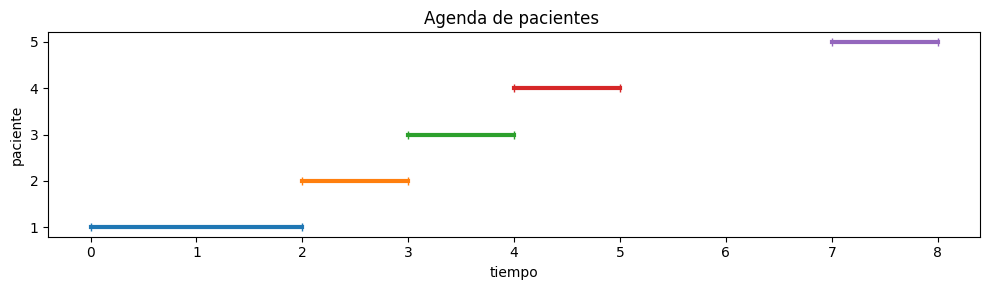

In [170]:
np.random.seed(15)
n_patients=5; n_enf=3
game = Game(n_patients, n_enf, p_short_stay=0.5, arrival_rate=4)
_=game.plot_pacientes()

# Validaciones

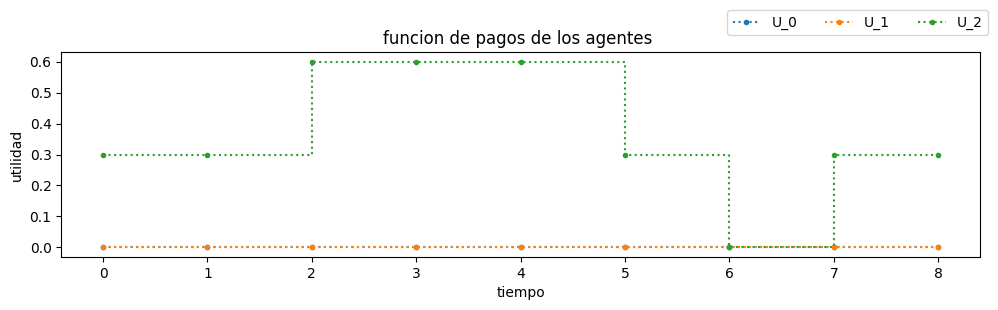

In [173]:
def always_i (enf, **kwargs):
    return enf, True

enf=2
u_0 = game.run_exp(funcion_acciones=partial(always_i, enf))
_ = game.plot_pagos(u_0)

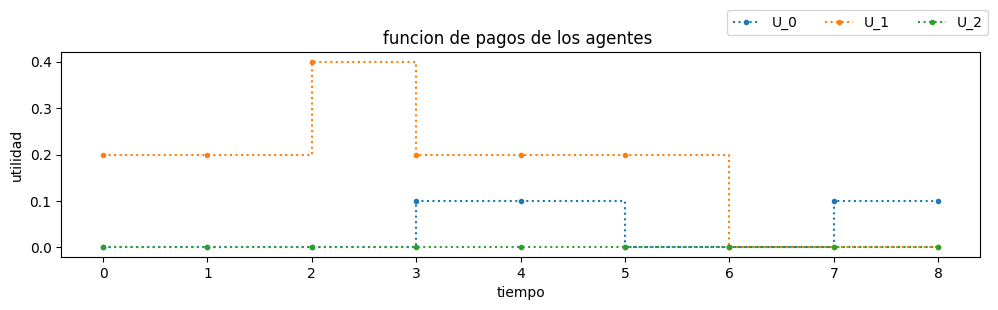

In [176]:
def never_i (enf, n_enf, **kwargs):
    return np.random.choice([i for i in range(n_enf) if i != enf]), True

enf=2
u_0 = game.run_exp(funcion_acciones=partial(never_i, enf))
_ = game.plot_pagos(u_0)

# Sensitivity analysis

In [177]:
import pandas as pd
from itertools import product  
from tqdm.notebook import tqdm
import scipy.stats as st


def run_strategy(strategy_function, strategy, result_row):
    '''recibe el array estrategia que indica que enfermero toma cada paciente
    guarda los resultados en results_row'''
    
    u_0=game.run_exp(funcion_acciones=partial(strategy_function, strategy))
    result_row['utilidad']=np.concatenate([game.summarize_utilities(u_0).flatten(), game.summarize_utilities(u_0).sum(axis=0)])
    return result_row

In [189]:
def create_results_table(exp_index, exp_values,runs):
    pagos_index=pd.MultiIndex.from_product([['utilidad'],['t%i'%i for i in range(n_patients)]+['total'],['U%i'%i for i in range(n_enf)]])
    resultados=pd.DataFrame(index=range(len(exp_values)), columns=exp_index.append(pagos_index)).sort_index()
    resultados['historia']=exp_values
    resultados=pd.concat([resultados]*runs, keys=range(runs)).sort_index()
    return resultados

def plot_aggregated_results(agg_, xlabel, title, alt_xticks=None):
    means=agg_.xs(('utilidad','total','mean'),level=[0,1,3],axis=1)
    intervals=agg_['utilidad','total'].groupby(level=0,axis=1).apply(lambda x: st.t.interval(0.9, 
                                                                                             x[x.name,'count']-1, 
                                                                                             x[x.name,'mean'], 
                                                                                             x[x.name,'sem']))
    fig, axs = plt.subplots(n_enf,1, sharex=True, figsize=(10,6))
    fig.suptitle(title)

    for i, ax in enumerate (axs):
        aux_df=means.iloc[:,i]#.sort_values(ascending=True)
        aux_df.plot(ax=ax, use_index=False)
        inf, up = intervals[i]
        ax.fill_between(np.arange(aux_df.shape[0]), inf[aux_df.index], up[aux_df.index],color='lightgrey')
        if i==0: ax.legend(['media', 'intervalo confianza - 90%'],ncol=2)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('utilidad U%i'%i)
        
    if alt_xticks is not None: plt.xticks(np.arange(aux_df.shape[0]), alt_xticks)
    fig.tight_layout()
    return fig

## 1. Comparar todas las posibles estrategias puras variando los parametros que dominan la longitud de estadia, el tiempo entre llegadas y numero de pacientes

In [181]:
def pure_strategy (strategy, assignment, patient,**kwargs):
    try:
        enf=strategy[patient].index('A')
        return enf, True
    except ValueError:
        enf=assignment.astype(bool).sum(axis=1).argmin()
        return enf, False

pure_strategies=product(product(['A','R'],repeat=n_enf),repeat=n_patients)

In [182]:
runs=50
historia_index=pd.MultiIndex.from_product([['historia'],['t%i'%i for i in range(n_patients)],['S%i'%i for i in range(n_enf)]])
historia_values=np.array(list(pure_strategies)).reshape(-1,n_patients*n_enf)
resultados=create_results_table(historia_index, historia_values,runs)

for run in tqdm(resultados.index.get_level_values(0).unique()):
    resultados.loc[run]=resultados.loc[run].apply(lambda row: run_strategy(pure_strategy, row.historia, row), axis=1).values
    game.reset_patients()

  0%|          | 0/50 [00:00<?, ?it/s]

In [183]:
resultados.to_csv('resultados_estrategiaspuras_5pacientes_3enfermeros.csv')

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


utilidad                                                             ...  \
        t0                                                             ...   
        U0                               U1                   U2       ...   
     count   mean       sem       std count mean  sem  std count mean  ...   
0       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
1       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
2       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
3       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
4       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   

                                                                
      total                                                     
         U0             U1                   U2                 
        sem      std count mean  sem  std count mean  sem  std  
0  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
1  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
2  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
3  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
4  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  

[5 rows x 72 columns]

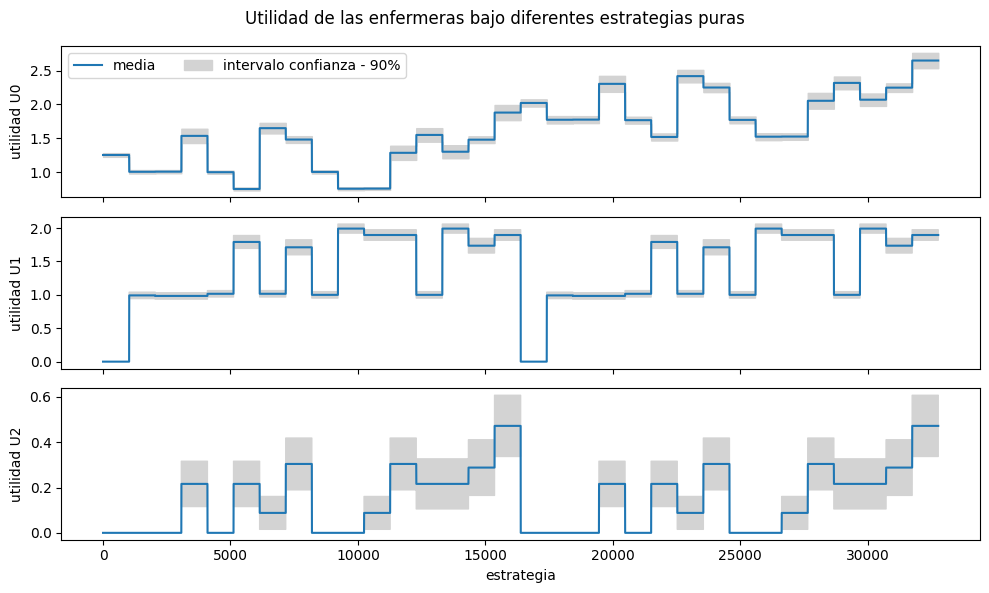

In [190]:
agg_=resultados[['utilidad']].groupby(level=1,axis=0).agg(["count","mean",st.sem,"std"])
fig = plot_aggregated_results(agg_, 'estrategia', 'Utilidad de las enfermeras bajo diferentes estrategias puras')

agg_.head()

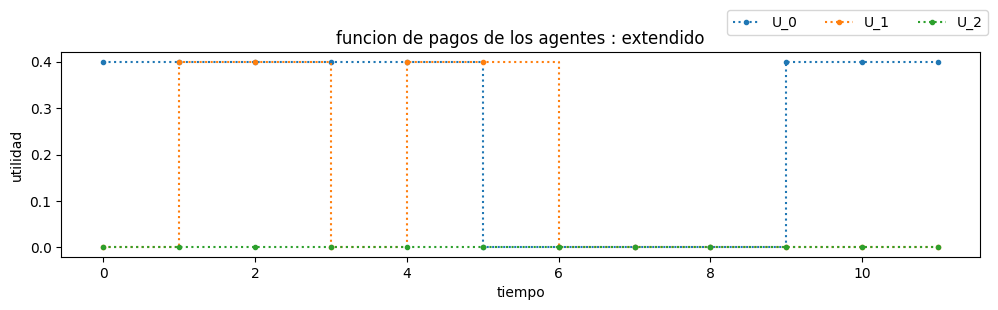

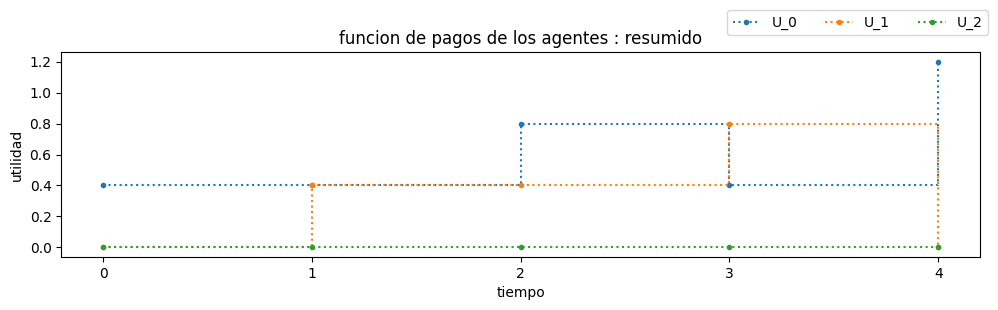

In [200]:
np.random.seed(None)
def mixed_strategies (p_aceptacion, assignment, n_enf, **kwargs):
    try:
        enf=np.random.choice(['acepta','rechaza'],p=[p_aceptacion,1-p_aceptacion],size=n_enf).tolist().index('acepta')
        return enf, True
    except ValueError:
        enf=assignment.astype(bool).sum(axis=1).argmin()
        return enf, False

p_aceptacion=0.1
u_0 = game.run_exp(funcion_acciones=partial(mixed_strategies,p_aceptacion))
_ = game.plot_pagos(u_0,': extendido')
_ = game.plot_pagos(game.summarize_utilities(u_0),': resumido')

In [203]:
from tqdm.notebook import trange

runs=50
prob_index=pd.MultiIndex.from_arrays([['historia'],[''],['p']])
prob_values=np.linspace(0,1,11)
resultados=create_results_table(prob_index,prob_values,runs)

for run in tqdm(resultados.index.get_level_values(0).unique()):
    resultados.loc[run]=resultados.loc[run].apply(lambda row: run_strategy(mixed_strategies, row.historia.values[0], row), axis=1).values
    game.reset_patients()

resultados

  0%|          | 0/50 [00:00<?, ?it/s]

historia utilidad                                                    \
                     t0             t1             t2             t3        
             p       U0   U1   U2   U0   U1   U2   U0   U1   U2   U0   U1   
0  0       0.0      0.8  0.0  0.0  0.0  0.4  0.0  0.8  0.4  0.0  0.4  1.2   
   1       0.1      0.8  0.0  0.0  0.0  0.2  0.0  0.8  0.2  0.0  0.7  0.0   
   2       0.2      0.8  0.0  0.0  0.0  0.4  0.0  0.2  0.4  0.0  0.1  1.2   
   3       0.3      0.2  0.0  0.0  0.0  0.4  0.0  0.8  0.4  0.0  0.4  1.2   
   4       0.4      0.8  0.0  0.0  0.0  0.4  0.0  0.8  0.4  0.0  0.4  0.6   
...        ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
49 6       0.6      0.1  0.0  0.0  0.4  0.0  0.0  0.2  0.0  0.0  0.2  0.0   
   7       0.7      0.1  0.0  0.0  0.4  0.0  0.0  0.2  0.0  0.0  0.2  0.0   
   8       0.8      0.1  0.0  0.0  0.4  0.0  0.0  0.2  0.0  0.0  0.2  0.0   
   9       0.9      0.1  0.0  0.0  0.4  0.0  0.0  0.2  0.0  0.0  0.2  0.0   
   10      1.0      0.1  0.0  0.0  0.4  0.0  0.0  0.2  0.0  0.0  0.2  0.0   

                                           
             t4           total            
        U2   U0   U1   U2    U0   U1   U2  
0  0   0.0  1.2  0.0  0.0   3.2  2.0  0.0  
   1   0.0  0.3  0.0  0.0   2.6  0.4  0.0  
   2   0.0  0.0  0.6  0.0   1.1  2.6  0.0  
   3   0.0  0.3  0.0  0.0   1.7  2.0  0.0  
   4   0.0  0.0  0.6  0.0   2.0  2.0  0.0  
...    ...  ...  ...  ...   ...  ...  ...  
49 6   0.0  0.0  0.8  0.0   0.9  0.8  0.0  
   7   0.0  0.2  0.0  0.0   1.1  0.0  0.0  
   8   0.0  0.0  0.4  0.0   0.9  0.4  0.0  
   9   0.0  0.2  0.0  0.0   1.1  0.0  0.0  
   10  0.0  0.2  0.0  0.0   1.1  0.0  0.0  

[550 rows x 19 columns]

In [204]:
resultados.to_csv('resultados_estrategiasmixtas_5pacientes_3enfermeros.csv')

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


utilidad                                                                    \
        t0                                                                     
        U0                               U1                               U2   
     count   mean       sem       std count   mean       sem       std count   
0       50  0.632  0.038059  0.269118    50  0.000  0.000000  0.000000    50   
1       50  0.482  0.047783  0.337875    50  0.012  0.008871  0.062727    50   
2       50  0.320  0.051429  0.363655    50  0.060  0.020000  0.141421    50   
3       50  0.194  0.035157  0.248596    50  0.104  0.024405  0.172568    50   
4       50  0.262  0.041492  0.293390    50  0.036  0.014780  0.104511    50   

          ...                                                             \
          ...     total                                                    
          ...        U0              U1                               U2   
    mean  ...       sem       std count   mean       sem       std count   
0  0.000  ...  0.067118  0.474595    50  1.864  0.051884  0.366873    50   
1  0.072  ...  0.086898  0.614465    50  1.652  0.081177  0.574008    50   
2  0.090  ...  0.106735  0.754729    50  1.352  0.085630  0.605499    50   
3  0.042  ...  0.092401  0.653371    50  1.360  0.080812  0.571429    50   
4  0.048  ...  0.094871  0.670839    50  0.964  0.100560  0.711067    50   

                              
                              
                              
    mean       sem       std  
0  0.408  0.073615  0.520533  
1  0.580  0.092890  0.656832  
2  0.656  0.099925  0.706576  
3  0.542  0.076830  0.543267  
4  0.642  0.113716  0.804094  

[5 rows x 72 columns]

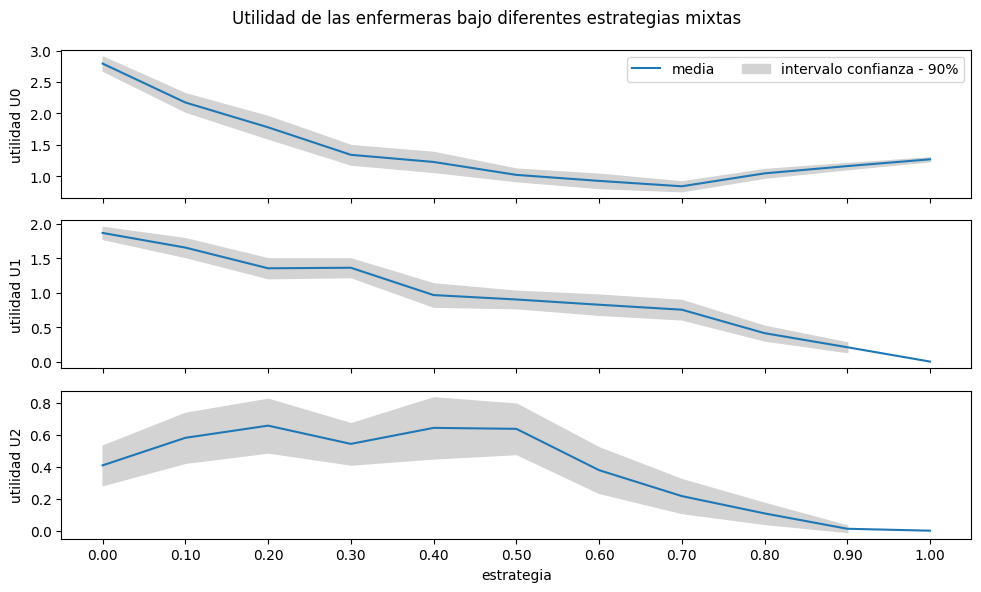

In [206]:
agg_=resultados[['utilidad']].groupby(level=1,axis=0).agg(["count","mean",st.sem,"std"])
fig = plot_aggregated_results(agg_, 'estrategia', 'Utilidad de las enfermeras bajo diferentes estrategias mixtas',
                              alt_xticks=['%.2f'%p for p in prob_values])

agg_.head()